### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
from sklearn import *
import time
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nltk.metrics.distance  import edit_distance
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
import tensorflow
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Embedding,LSTM, SpatialDropout1D
from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.layers import Dropout
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings("ignore")

### Data Preprocessing

In [2]:
def dataClean(tweets_raw):
    cleanTweets = []
    for tweet in tweets_raw:
        tweet = tweet.lower() #convert to lowercase
        tweet = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', tweet) #remove URL
        tweet = re.sub(r'(\s)@\w+', r'', tweet) #remove usernames
        tweet = re.sub(r'@\w+', r'', tweet) #remove usernames
        tweet = re.sub('<[^<]+?>', '', tweet) #remove HTML tags
        # tweet = re.sub(r'[<>!#@$:.,%\?-]+', r'', tweet) #remove punctuation and special characters
        tweet = re.sub('[^A-Za-z0-9 ]+', '', tweet)
        tweet = re.sub(" \d+", " ", tweet) #remove standalone numbers
        lower_case = tweet.lower() #tokenization
        
        words = lower_case.split()
        tweet = ' '.join([w for w in words if not w in nltk.corpus.stopwords.words("english")]) #remove stopwords
        ps = nltk.stem.PorterStemmer()
        stemmedTweet = [ps.stem(word) for word in tweet.split(" ")]
        stemmedTweet = " ".join(stemmedTweet)
        tweet = str(stemmedTweet)
        tweet = tweet.replace("'", "")
        tweet = tweet.replace("\"","")

        cleanTweets.append(tweet)
        
    return cleanTweets

In [3]:
trainingFile = "training-Obama-Romney-tweets.xlsx"
df_obama = pd.read_excel(trainingFile,sheet_name='Obama')
df_romney = pd.read_excel(trainingFile,sheet_name='Romney')

In [4]:
df_obama.drop(df_obama.columns[0], axis=1, inplace = True)
df_obama.drop(df_obama.columns[4:], axis=1, inplace = True)

df_obama.drop([0],inplace=True)
df_obama.rename(columns={df_obama.columns[3]: 'Class'}, inplace = True)

In [5]:
df_romney.drop(df_romney.columns[0], axis=1, inplace = True)
df_romney.drop(df_romney.columns[4:], axis=1, inplace = True)

df_romney.drop([0],inplace=True)
df_romney.rename(columns={df_romney.columns[3]: 'Class'}, inplace = True)

In [6]:
df_obama = df_obama[(df_obama['Class'].isin((1,-1)))]
df_romney = df_romney[(df_romney['Class'].isin((1,-1)))]

In [7]:
obama_tweets_raw = df_obama['Anootated tweet']
obama_class = df_obama['Class']
romney_tweets_raw = df_romney['Anootated tweet']
romney_class = df_romney['Class']

In [8]:
obama_tweets_raw = obama_tweets_raw.tolist()
romney_tweets_raw = romney_tweets_raw.tolist()

In [9]:
obama_class_train = obama_class.tolist()
romney_class_train = romney_class.tolist()

In [10]:
obama_tweets = dataClean(obama_tweets_raw)
romney_tweets = dataClean(romney_tweets_raw)

## ***LSTM - Obama***

In [11]:
# obama_tweets, obama_class_train
obama_df = pd.DataFrame(obama_tweets, columns=['Annotated tweet'])
obama_df['Class'] = obama_class_train
obama_df["Class"].replace({-1: 0}, inplace=True)

sentiment_obama = obama_df['Class'].values
data_obama = obama_df['Annotated tweet']

In [12]:
x_train, x_test, y_train, y_test = train_test_split(data_obama, sentiment_obama, test_size = 0.2, random_state = 42)

In [13]:
tokenizer = Tokenizer(num_words = 1500)
tokenizer.fit_on_texts(data_obama)

In [14]:
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

In [15]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

In [16]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

14

In [17]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9583216783216784

In [18]:
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens)

In [19]:
x_train_pad.shape

(2860, 14)

In [20]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

def return_to_sentence(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

In [21]:
print(return_to_sentence(x_train_pad[9]))

poll isra think obama favor israel palestinian tcot


In [22]:
print(x_train_pad[9])

[   0    0    0    0    0    0   56  896   19    1  617  330 1057   28]


In [23]:
model = Sequential()

embedding_size = 32

model.add(Embedding(input_dim=1500,output_dim=embedding_size,input_length=max_tokens,name='embedding_layer'))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=1e-3)

model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 14, 32)            48000     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 14, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 64,651
Trainable params: 64,651
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(x_train_pad, y_train, validation_split=0.2, epochs=8, batch_size=200, shuffle=True, verbose = 1)

Epoch 1/8
12/12 [==============================] - 0s 29ms/step - loss: 0.6907 - accuracy: 0.5533 - val_loss: 0.6846 - val_accuracy: 0.5944
Epoch 2/8
12/12 [==============================] - 0s 11ms/step - loss: 0.6805 - accuracy: 0.6036 - val_loss: 0.6673 - val_accuracy: 0.6976
Epoch 3/8
12/12 [==============================] - 0s 12ms/step - loss: 0.6568 - accuracy: 0.6455 - val_loss: 0.6346 - val_accuracy: 0.6626
Epoch 4/8
12/12 [==============================] - 0s 12ms/step - loss: 0.6147 - accuracy: 0.6700 - val_loss: 0.6096 - val_accuracy: 0.6958
Epoch 5/8
12/12 [==============================] - 0s 12ms/step - loss: 0.5778 - accuracy: 0.7072 - val_loss: 0.5827 - val_accuracy: 0.7395
Epoch 6/8
12/12 [==============================] - 0s 12ms/step - loss: 0.5271 - accuracy: 0.7605 - val_loss: 0.5693 - val_accuracy: 0.7430
Epoch 7/8
12/12 [==============================] - 0s 12ms/step - loss: 0.4771 - accuracy: 0.7854 - val_loss: 0.5620 - val_accuracy: 0.7325
Epoch 8/8
12/12 [===

### ***Performance Analysis - Obama***

In [26]:
result = model.evaluate(x_test_pad, y_test)

23/23 [==============================] - 0s 696us/step - loss: 0.5344 - accuracy: 0.7385


In [27]:
pred = (model.predict(x_test_pad) > 0.5).astype("int32")
cm = confusion_matrix(y_test, pred)
pred = pred[:, 0]
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.78      0.71      0.74       381
           1       0.70      0.78      0.73       334

    accuracy                           0.74       715
   macro avg       0.74      0.74      0.74       715
weighted avg       0.74      0.74      0.74       715



In [28]:
cm = confusion_matrix(y_test, pred)
cm

array([[269, 112],
       [ 75, 259]], dtype=int64)

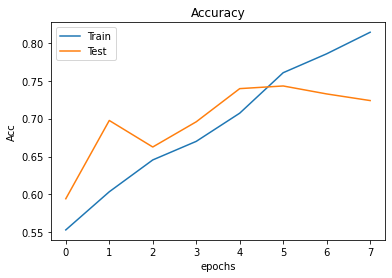

In [29]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

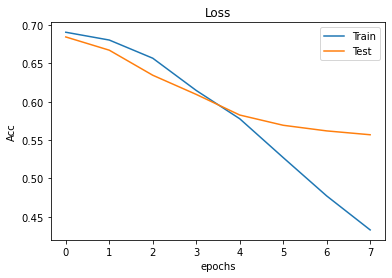

In [30]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

### ***LSTM - Romney***

In [31]:
# obama_tweets, obama_class_train
romney_df = pd.DataFrame(romney_tweets, columns=['Annotated tweet'])
romney_df['Class'] = romney_class_train
romney_df["Class"].replace({-1: 0}, inplace=True)

sentiment_romney = romney_df['Class'].values
data_romney = romney_df['Annotated tweet']

In [32]:
x_train, x_test, y_train, y_test = train_test_split(data_romney,sentiment_romney,test_size = 0.2, random_state = 42)

In [33]:
tokenizer = Tokenizer(num_words = 1500)
tokenizer.fit_on_texts(data_romney)

In [34]:
x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

In [35]:
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens)

In [36]:
x_train_pad.shape

(3174, 14)

In [37]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

def return_to_sentence(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

In [38]:
print(return_to_sentence(x_train_pad[9]))

romney great us lose massachusett


In [39]:
print(x_train_pad[9])

[  0   0   0   0   0   0   0   0   0   1 104  30 160 260]


In [40]:
model = Sequential()

embedding_size = 32

model.add(Embedding(input_dim=1500,output_dim=embedding_size,input_length=max_tokens,name='embedding_layer'))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(lr=1e-3)

model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 14, 32)            48000     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 14, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 64,651
Trainable params: 64,651
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(x_train_pad, y_train, validation_split=0.2, epochs=8, batch_size=200, shuffle=True, verbose = 1)

Epoch 1/8
13/13 [==============================] - 0s 24ms/step - loss: 0.6776 - accuracy: 0.6904 - val_loss: 0.6464 - val_accuracy: 0.7433
Epoch 2/8
13/13 [==============================] - 0s 10ms/step - loss: 0.6198 - accuracy: 0.7192 - val_loss: 0.5731 - val_accuracy: 0.7433
Epoch 3/8
13/13 [==============================] - 0s 10ms/step - loss: 0.5967 - accuracy: 0.7192 - val_loss: 0.5740 - val_accuracy: 0.7433
Epoch 4/8
13/13 [==============================] - 0s 10ms/step - loss: 0.5802 - accuracy: 0.7192 - val_loss: 0.5513 - val_accuracy: 0.7433
Epoch 5/8
13/13 [==============================] - 0s 11ms/step - loss: 0.5556 - accuracy: 0.7196 - val_loss: 0.5337 - val_accuracy: 0.7433
Epoch 6/8
13/13 [==============================] - 0s 10ms/step - loss: 0.5225 - accuracy: 0.7247 - val_loss: 0.5046 - val_accuracy: 0.7512
Epoch 7/8
13/13 [==============================] - 0s 10ms/step - loss: 0.4779 - accuracy: 0.7562 - val_loss: 0.4847 - val_accuracy: 0.7795
Epoch 8/8
13/13 [===

### ***Performance Analysis - Romney***

In [43]:
result = model.evaluate(x_test_pad, y_test)

25/25 [==============================] - 0s 760us/step - loss: 0.4787 - accuracy: 0.7997


In [44]:
pred = (model.predict(x_test_pad) > 0.4).astype("int32")
cm = confusion_matrix(y_test, pred)
pred = pred[:, 0]
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       595
           1       0.62      0.52      0.57       199

    accuracy                           0.80       794
   macro avg       0.74      0.71      0.72       794
weighted avg       0.79      0.80      0.79       794



In [45]:
cm = confusion_matrix(y_test, pred)
cm

array([[533,  62],
       [ 96, 103]], dtype=int64)

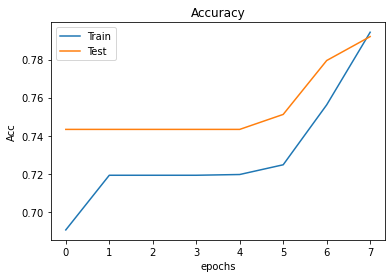

In [46]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

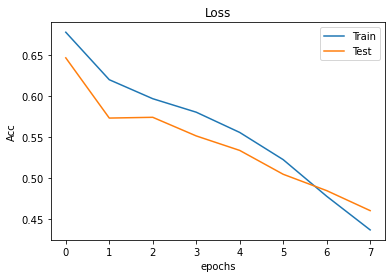

In [47]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()